## ■ Import Modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D
from keras.models import Model, load_model, save_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


# Load Dataset

In [3]:
x_train = np.load('E:\ct_lung\CT_lung_segmentation-master\dataset\\x_train.npy')
y_train = np.load('E:\ct_lung\CT_lung_segmentation-master\dataset\\y_train.npy')
x_val = np.load('E:\ct_lung\CT_lung_segmentation-master\dataset\\x_val.npy')
y_val = np.load('E:\ct_lung\CT_lung_segmentation-master\dataset\\y_val.npy')

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(240, 256, 256, 1) (240, 256, 256, 1)
(27, 256, 256, 1) (27, 256, 256, 1)


# Build Model

In [4]:
inputs = Input(shape=(256, 256, 1))

# Downsampling
net = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D(64, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D(128, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Dense(128, activation='relu')(net)

# Upsampling
net = UpSampling2D(size=2)(net)
net = Conv2D(128, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
net = Conv2D(64, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
outputs = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 'mse']) # 이진분류이므로 binary_corssentropy_error(BEE)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 128)       0   

# If Model exist

In [5]:
# 로드한 model에 weight 로드하기

model_exists = True

if model_exists:
    
    model.load_weights('E:\ct_lung\CT_lung_segmentation-master\models\\result.h5')
    
print("Loaded model from disk")

Loaded model from disk


In [6]:
# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 'mse'])

# 모델 evaluation
loss, acc, mse = model.evaluate(x_train, y_train)
val_loss, val_acc, val_mse = model.evaluate(x_val, y_val) 

print("Train_Accuracy : %.2f%%" % (acc*100))
print("Val_Accuracy : %.2f%%" % (val_acc*100))
print("Train_mse : %.4f" % (mse))
print("Val_mse : %.4f" % (val_mse))

27/27 [==============================] - 1s 28ms/step
Train_Accuracy : 96.29%
Val_Accuracy : 96.32%
Train_mse : 0.0062
Val_mse : 0.0067


# Train ( Not exist models )

In [12]:
# earlystopper = EarlyStopping(patience=5, verbose=1)

checkpointer = ModelCheckpoint('E:\ct_lung\CT_lung_segmentation-master\models\\result.h5', verbose=1, save_best_only=True)

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, callbacks=[
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
, checkpointer])

scores = model.evaluate(x_val, y_val, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

# ReduceLROnPlateau : val_loss가 향상되지 않을 때 학습률을 작게 할 수 있습니다.
# factor = 0.2 -> callback 호출시 learning rate를 0.2배로 줄임
# patience = 10 -> (callback 이 발생할시 10epoch 진행)
# min_lr -> 최소 learning rate 설정 (1e-05)
# verbose = 1 -> 정보 제공 방법

# save_model(model, "E:\ct_lung\CT_lung_segmentation-master\models\\result.h5")

Train on 240 samples, validate on 27 samples
Epoch 1/100
240/240 [==============================] - 3s 13ms/step - loss: 0.5889 - acc: 0.7499 - mse: 0.1903 - val_loss: 0.5206 - val_acc: 0.7607 - val_mse: 0.1684

Epoch 00001: val_loss improved from inf to 0.52058, saving model to E:\ct_lung\CT_lung_segmentation-master\models\result.h5
Epoch 2/100
240/240 [==============================] - 1s 4ms/step - loss: 0.5076 - acc: 0.7501 - mse: 0.1655 - val_loss: 0.4886 - val_acc: 0.7607 - val_mse: 0.1582

Epoch 00002: val_loss improved from 0.52058 to 0.48860, saving model to E:\ct_lung\CT_lung_segmentation-master\models\result.h5
Epoch 3/100
240/240 [==============================] - 1s 4ms/step - loss: 0.4678 - acc: 0.7501 - mse: 0.1535 - val_loss: 0.4585 - val_acc: 0.7607 - val_mse: 0.1493

Epoch 00003: val_loss improved from 0.48860 to 0.45845, saving model to E:\ct_lung\CT_lung_segmentation-master\models\result.h5
Epoch 4/100
240/240 [==============================] - 1s 4ms/step - loss: 0


Epoch 00065: val_loss did not improve from 0.04352
Epoch 66/100
240/240 [==============================] - 1s 4ms/step - loss: 0.0504 - acc: 0.9588 - mse: 0.0104 - val_loss: 0.0435 - val_acc: 0.9600 - val_mse: 0.0092

Epoch 00066: val_loss improved from 0.04352 to 0.04347, saving model to E:\ct_lung\CT_lung_segmentation-master\models\result.h5
Epoch 67/100
240/240 [==============================] - 1s 4ms/step - loss: 0.0511 - acc: 0.9584 - mse: 0.0106 - val_loss: 0.0911 - val_acc: 0.9456 - val_mse: 0.0225

Epoch 00067: val_loss did not improve from 0.04347
Epoch 68/100
240/240 [==============================] - 1s 4ms/step - loss: 0.0549 - acc: 0.9568 - mse: 0.0119 - val_loss: 0.0658 - val_acc: 0.9546 - val_mse: 0.0145

Epoch 00068: val_loss did not improve from 0.04347
Epoch 69/100
240/240 [==============================] - 1s 4ms/step - loss: 0.0519 - acc: 0.9587 - mse: 0.0106 - val_loss: 0.0702 - val_acc: 0.9528 - val_mse: 0.0161

Epoch 00069: val_loss did not improve from 0.04347

# Evaluation

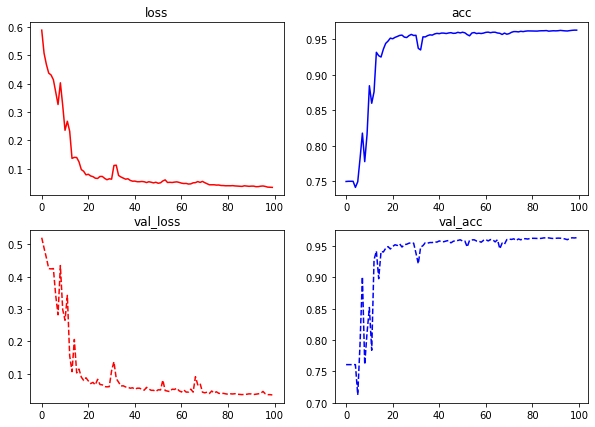

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('acc')
ax[0, 1].plot(history.history['acc'], 'b')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_acc')
ax[1, 1].plot(history.history['val_acc'], 'b--')

(27, 256, 256, 1)
(27, 256, 256, 1)
(27, 256, 256, 1)


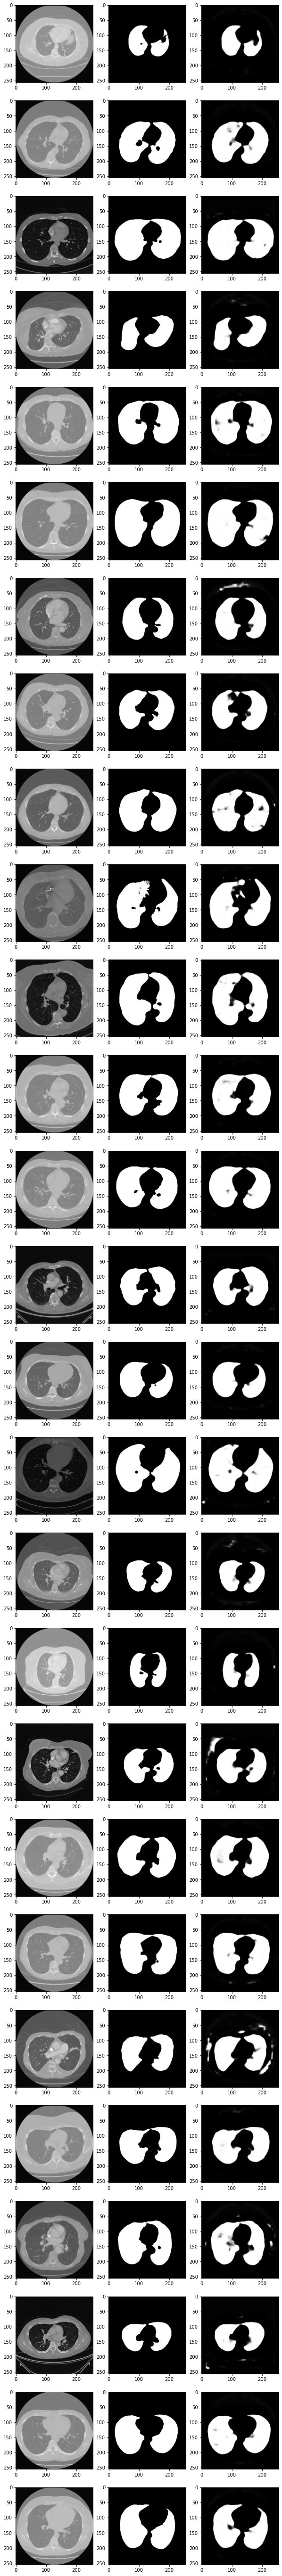

In [14]:
print(x_val.shape)
print(y_val.shape)

preds = model.predict(x_val)
print(preds.shape)
fig, ax = plt.subplots(len(x_val), 3, figsize=(10, 100))

for i, pred in enumerate(preds):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray') # CT 사진 원본
    ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray') # Mask 사진 원본
    ax[i, 2].imshow(pred.squeeze(), cmap='gray') # 만들어낸 Mask 사진 (training 결과)

(7, 256, 256, 1)
(7, 256, 256, 1)
(7, 256, 256, 1)


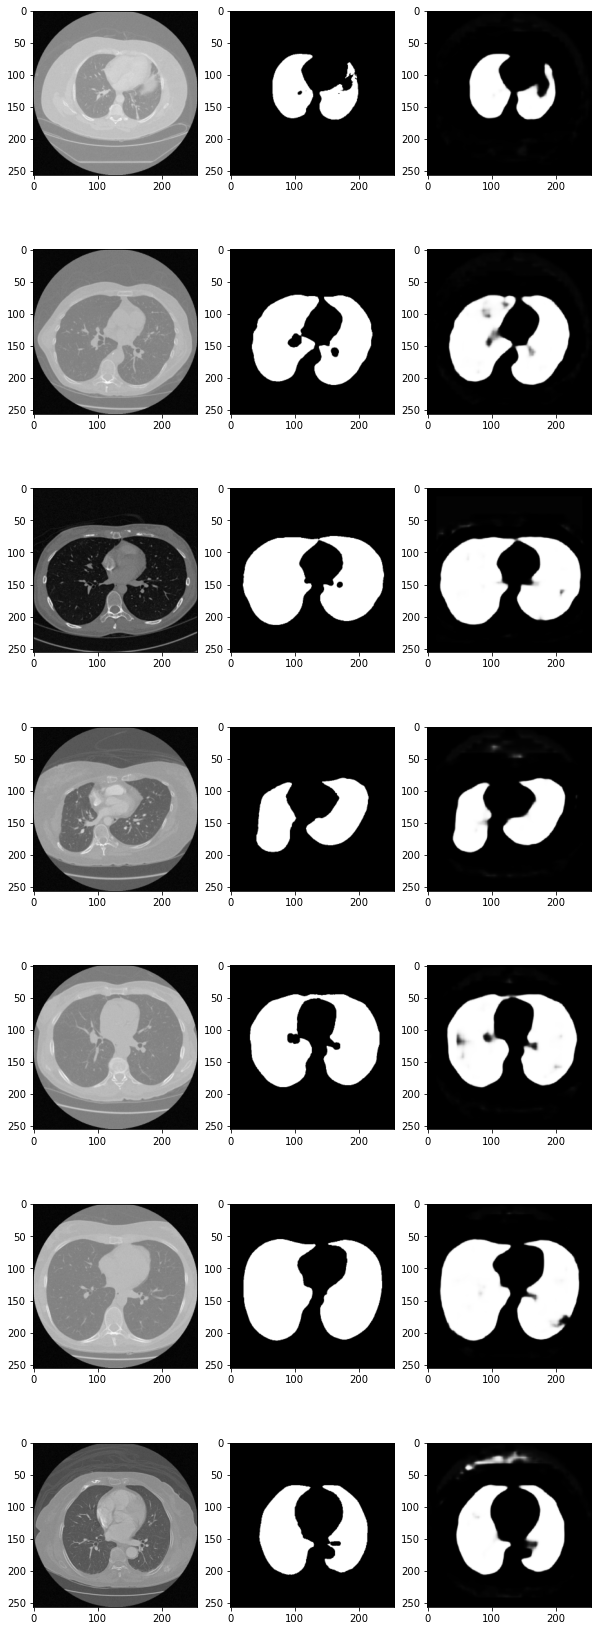

In [8]:
x_val2 = x_val[0:7]
y_val2 = y_val[0:7]

print(x_val2.shape)
print(y_val2.shape)

preds = model.predict(x_val2)
print(preds.shape)
fig, ax = plt.subplots(len(x_val2), 3, figsize=(10, 30))

for i, pred in enumerate(preds):
    ax[i, 0].imshow(x_val2[i].squeeze(), cmap='gray') # CT 사진 원본
    ax[i, 1].imshow(y_val2[i].squeeze(), cmap='gray') # Mask 사진 원본
    ax[i, 2].imshow(pred.squeeze(), cmap='gray') # 만들어낸 Mask 사진 (training 결과)